In [88]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [89]:
import pandas as pd
import torch
from datetime import datetime, timedelta
# Đọc dữ liệu từ file CSV
df = pd.read_csv('DXG-Historical-Data.csv')

In [90]:
# # Chuyển dữ liệu thời gian
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
# # Đảo ngược lại dữ liệu
# df = df.iloc[::-1].reset_index(drop=True)

In [91]:
# # Loại bỏ dấu phẩy từ cột "Price"
# df['Price'] = df['Price'].str.replace(',', '').astype(float)
# # Loại bỏ dấu phẩy từ cột "Open"
# df['Open'] = df['Open'].str.replace(',', '').astype(float)
# # Loại bỏ dấu phẩy từ cột "High"
# df['High'] = df['High'].str.replace(',', '').astype(float)
# # Loại bỏ dấu phẩy từ cột "Low"
# df['Low'] = df['Low'].str.replace(',', '').astype(float)

In [92]:
df

,Unnamed: 0,Date,Price
0,0,2017-01-03,6066.50
1,1,2017-01-04,6166.40
2,2,2017-01-05,6091.50
3,3,2017-01-06,6141.40
4,4,2017-01-07,6116.45
...,...,...,...
2702,2702,2024-05-28,16800.00
2703,2703,2024-05-29,16850.00
2704,2704,2024-05-30,16850.00
2705,2705,2024-05-31,16800.00


In [107]:
# Lấy ngày cuối cùng của dữ liệu
df['Date'] = pd.to_datetime(df['Date'])
last_date = df['Date'].max()


In [108]:
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test
time_series_Date = df['Date']

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra - để lấy date
train_data_Date = time_series_Date[:int(0.7 * len(time_series_Date))]
test_data_Date = time_series_Date[int(0.7 * len(time_series_Date)):]
first_data_Date = test_data_Date.min()
print(first_data_Date)

2022-03-12 00:00:00


In [95]:
# Lấy dữ liệu cần phân tích
time_series_price = df['Price']

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data_price = time_series_price[:int(0.7 * len(time_series_price))]
test_data_price = time_series_price[int(0.7 * len(time_series_price)):]

# Chọn các cột dữ liệu số
# numeric_columns = ['Price', 'Open', 'High', 'Low']
numeric_columns = ['Price']

# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)

# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Chia dữ liệu thành tensor
input_data_train = torch.tensor(numeric_data[:, :len(train_data_price), :])
input_data_test = torch.tensor(numeric_data[:, len(train_data_price):, :])
# Lấy dữ liệu 20 ngày gần nhất
recent_20_prices = time_series_price[-20:]

# Chuyển đổi dữ liệu 20 ngày gần nhất thành numpy array và mở rộng chiều
recent_20_prices_array = recent_20_prices.values.astype(np.float32)
recent_20_prices_array = np.expand_dims(recent_20_prices_array, axis=0)
recent_20_prices_array = np.expand_dims(recent_20_prices_array, axis=-1)

# Chuyển đổi thành tensor
input_data_20day = torch.tensor(recent_20_prices_array)

# In ra để kiểm tra kích thước của các tensor
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập kiểm tra:", input_data_test.shape)

Kích thước tập huấn luyện: torch.Size([1, 1894, 1])
Kích thước tập kiểm tra: torch.Size([1, 813, 1])


In [96]:
# Khởi tạo cấu hình cho model
class Configs:
    def __init__(self):
        self.seq_len = 1894  # Độ dài chuỗi thời gian đầu vào(tập kiểm tra)
        self.pred_len = 1894  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model = Model(configs)

In [97]:
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model(input_data_train)

    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 45013608.0000
Epoch [2/100], Loss: 680163200.0000
Epoch [3/100], Loss: 69914904.0000
Epoch [4/100], Loss: 147012608.0000
Epoch [5/100], Loss: 372723904.0000
Epoch [6/100], Loss: 252873936.0000
Epoch [7/100], Loss: 53094980.0000
Epoch [8/100], Loss: 21363758.0000
Epoch [9/100], Loss: 131761704.0000
Epoch [10/100], Loss: 191898768.0000
Epoch [11/100], Loss: 131875232.0000
Epoch [12/100], Loss: 39476828.0000
Epoch [13/100], Loss: 12221516.0000
Epoch [14/100], Loss: 55038972.0000
Epoch [15/100], Loss: 96926560.0000
Epoch [16/100], Loss: 86802152.0000
Epoch [17/100], Loss: 42683088.0000
Epoch [18/100], Loss: 13596066.0000
Epoch [19/100], Loss: 21072424.0000
Epoch [20/100], Loss: 43795064.0000
Epoch [21/100], Loss: 50508092.0000
Epoch [22/100], Loss: 35203936.0000
Epoch [23/100], Loss: 16589090.0000
Epoch [24/100], Loss: 11967366.0000
Epoch [25/100], Loss: 19665474.0000
Epoch [26/100], Loss: 25995342.0000
Epoch [27/100], Loss: 22850706.0000
Epoch [28/100], Loss: 14498053

In [98]:
# Dự báo cho tập test
# # Chuyển sang chế độ đánh giá
model.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future_test = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted_test = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(813):  # Dự báo cho tập test
        # Dự báo cho ngày hiện tại
        output = model(input_data_future_test)
        # Lưu dự báo của ngày hiện tại
        predicted_test.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future_test = torch.cat([input_data_future_test[:, :, 1:], output], dim=2)

    # In ra dự báo cho tập test
    print("Predicted Output for data test:")
    for i in range(813):
        # In ra ngày tương ứng với dự báo
        print(f"Day  Predicted: {predicted_test[i][0]}")


Predicted Output for data test:
Day  Predicted: tensor([40627.7070])
Day  Predicted: tensor([40628.3086])
Day  Predicted: tensor([40626.7578])
Day  Predicted: tensor([40625.1406])
Day  Predicted: tensor([40623.5234])
Day  Predicted: tensor([40621.9062])
Day  Predicted: tensor([40620.2891])
Day  Predicted: tensor([40618.6641])
Day  Predicted: tensor([40617.0469])
Day  Predicted: tensor([40615.4336])
Day  Predicted: tensor([40613.8125])
Day  Predicted: tensor([40612.1953])
Day  Predicted: tensor([40610.5703])
Day  Predicted: tensor([40608.9531])
Day  Predicted: tensor([40607.3320])
Day  Predicted: tensor([40605.7148])
Day  Predicted: tensor([40604.0977])
Day  Predicted: tensor([40602.4844])
Day  Predicted: tensor([40600.8633])
Day  Predicted: tensor([40599.2461])
Day  Predicted: tensor([40597.6289])
Day  Predicted: tensor([40596.0156])
Day  Predicted: tensor([40594.3945])
Day  Predicted: tensor([40592.7812])
Day  Predicted: tensor([40591.1602])
Day  Predicted: tensor([40589.5391])
Day  P

In [99]:
# Khởi tạo cấu hình cho model
class Configs:
    def __init__(self):
        self.seq_len = 20  # Độ dài chuỗi thời gian đầu vào(tập kiểm tra)
        self.pred_len = 20  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model = Model(configs)

In [100]:
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model(input_data_20day)

    # Tính toán loss
    loss = criterion(outputs, input_data_20day)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 72061.6250
Epoch [2/100], Loss: 27433.7539
Epoch [3/100], Loss: 33798.1172
Epoch [4/100], Loss: 32974.3359
Epoch [5/100], Loss: 26444.7344
Epoch [6/100], Loss: 18223.2266
Epoch [7/100], Loss: 12470.6250
Epoch [8/100], Loss: 11757.9072
Epoch [9/100], Loss: 14537.9668
Epoch [10/100], Loss: 15454.7578
Epoch [11/100], Loss: 11975.3330
Epoch [12/100], Loss: 7408.8735
Epoch [13/100], Loss: 5933.2461
Epoch [14/100], Loss: 7485.0181
Epoch [15/100], Loss: 8502.9238
Epoch [16/100], Loss: 6957.2471
Epoch [17/100], Loss: 4511.1699
Epoch [18/100], Loss: 3697.5300
Epoch [19/100], Loss: 4623.6211
Epoch [20/100], Loss: 5231.5225
Epoch [21/100], Loss: 4250.9341
Epoch [22/100], Loss: 2638.7043
Epoch [23/100], Loss: 1993.3248
Epoch [24/100], Loss: 2511.9138
Epoch [25/100], Loss: 3063.1716
Epoch [26/100], Loss: 2793.9800
Epoch [27/100], Loss: 1993.9473
Epoch [28/100], Loss: 1414.9508
Epoch [29/100], Loss: 1322.8846
Epoch [30/100], Loss: 1454.4933
Epoch [31/100], Loss: 1512.5195
Epoch 

In [101]:
# Dự báo cho 90 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_20day.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(90):  # Dự báo cho 90 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 90 days:")
    for i in range(90):
        # In ra ngày tương ứng với dự báo
        print(f"Day  Predicted: {predicted[i][0]}")


Predicted Output for the next 90 days:
Day  Predicted: tensor([16771.4434])
Day  Predicted: tensor([16771.0762])
Day  Predicted: tensor([16770.7168])
Day  Predicted: tensor([16770.3613])
Day  Predicted: tensor([16770.0039])
Day  Predicted: tensor([16769.6465])
Day  Predicted: tensor([16769.2891])
Day  Predicted: tensor([16768.9316])
Day  Predicted: tensor([16768.5742])
Day  Predicted: tensor([16768.2188])
Day  Predicted: tensor([16767.8613])
Day  Predicted: tensor([16767.5039])
Day  Predicted: tensor([16767.1465])
Day  Predicted: tensor([16766.7910])
Day  Predicted: tensor([16766.4336])
Day  Predicted: tensor([16766.0781])
Day  Predicted: tensor([16765.7207])
Day  Predicted: tensor([16765.3633])
Day  Predicted: tensor([16765.0059])
Day  Predicted: tensor([16764.6523])
Day  Predicted: tensor([16764.2930])
Day  Predicted: tensor([16763.9375])
Day  Predicted: tensor([16763.5781])
Day  Predicted: tensor([16763.2227])
Day  Predicted: tensor([16762.8672])
Day  Predicted: tensor([16762.5098])

In [102]:
# Chuyển dữ liệu từ Series pandas thành numpy array để vẽ biểu đồ
predicted_values_test = [pred[0].numpy() for pred in predicted_test]
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]
# Tạo mảng chứa ngày của train_data_price
train_dates = df['Date'].values[:len(train_data_price)]
# Tạo mảng chứa ngày của test_data_price
test_dates = df['Date'].values[len(train_data_price):len(train_data_price)+len(test_data_price)]
# Tạo mảng chứa ngày dự đoán
predicted_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=len(predicted_values))

split_size = len(predicted_values) // 3

predicted_values_30day = predicted_values[:split_size]
predicted_values_60day = predicted_values[split_size:2*split_size]
predicted_values_90day = predicted_values[2*split_size:]
# Tính toán các khoảng thời gian cho mỗi phần
predicted_dates_30day = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=split_size)
predicted_dates_60day = pd.date_range(start=predicted_dates_30day[-1] + pd.DateOffset(days=1), periods=split_size)
predicted_dates_90day = pd.date_range(start=predicted_dates_60day[-1] + pd.DateOffset(days=1), periods=split_size)


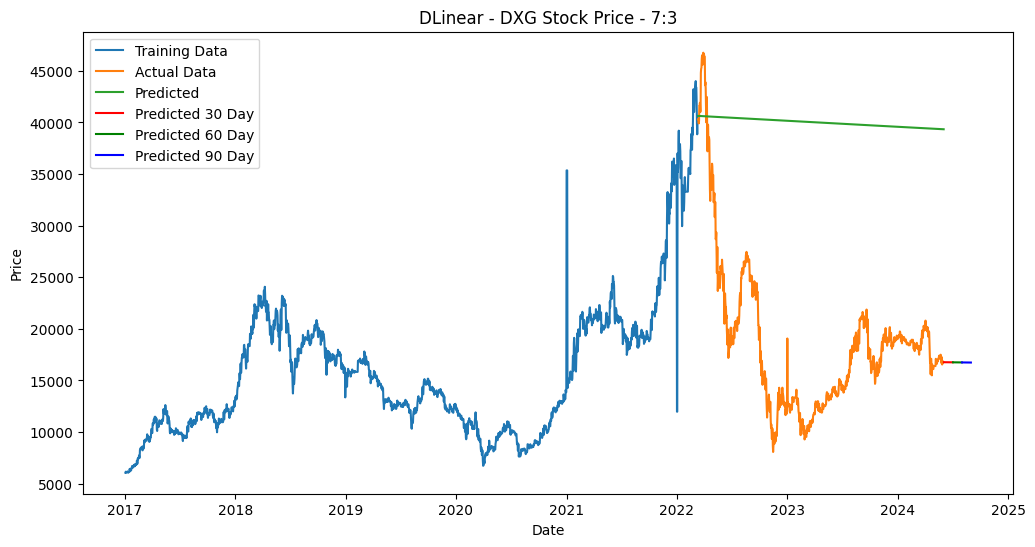

In [103]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_data_price, label='Training Data')
plt.plot(test_dates, test_data_price, label='Actual Data')
plt.plot(test_dates, predicted_values_test, label='Predicted')
plt.plot(predicted_dates_30day, predicted_values_30day, label='Predicted 30 Day', color='red')
plt.plot(predicted_dates_60day, predicted_values_60day, label='Predicted 60 Day', color='green')
plt.plot(predicted_dates_90day, predicted_values_90day, label='Predicted 90 Day', color='blue')

plt.title('DLinear - DXG Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


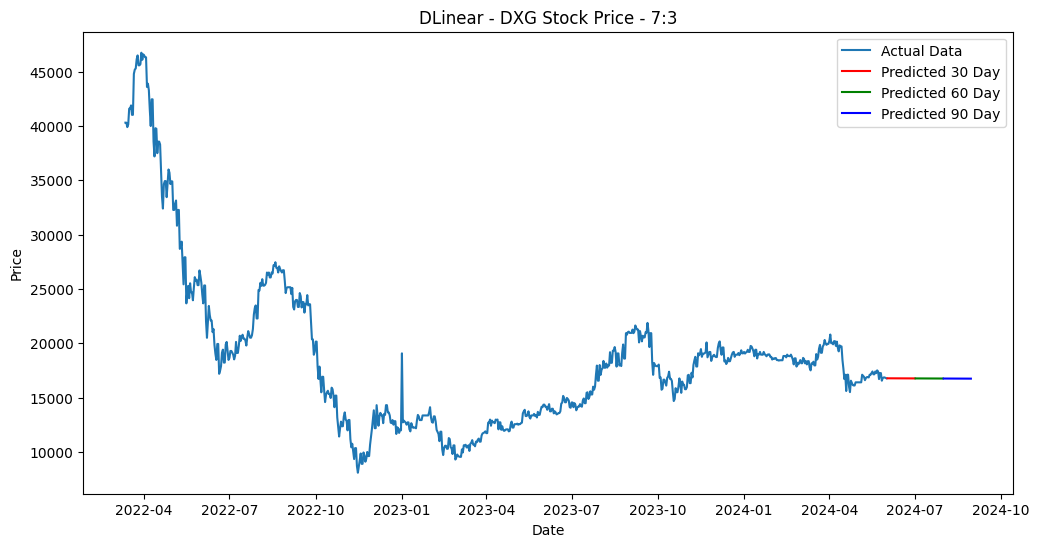

In [104]:
import matplotlib.pyplot as plt


# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_data_price, label='Actual Data')
plt.plot(predicted_dates_30day, predicted_values_30day, label='Predicted 30 Day', color='red')
plt.plot(predicted_dates_60day, predicted_values_60day, label='Predicted 60 Day', color='green')
plt.plot(predicted_dates_90day, predicted_values_90day, label='Predicted 90 Day', color='blue')

plt.title('DLinear - DXG Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [105]:
outputs_test = np.array(predicted_values_test)
outputs_test = outputs_test.flatten()

In [106]:
# Mean Absolute Error (MAE) và Mean Absolute Percentage Error (MAPE)
mae_test = np.mean(np.abs(test_data_price - outputs_test))
mape_test = np.mean(np.abs((test_data_price - outputs_test) / test_data_price)) * 100
rmse_test = np.sqrt(np.mean((test_data_price - outputs_test) ** 2))

print("MAE:", mae_test)
print("MAPE:", mape_test)
print("RMSE:", rmse_test)

MAE: 21506.28629913643
MAPE: 140.128150867899
RMSE: 22437.80183742448
